# Time series clustering exercise


In [78]:
import os
import ast
import urllib2
import urllib
import pandas as pd
import json
from cStringIO import StringIO
import scipy.stats
from scipy.cluster.vq import whiten
from matplotlib import gridspec
from sklearn.cluster import KMeans
from pandas.tools.plotting import scatter_matrix
import geopandas as gp
import glob
from fiona.crs import from_epsg
import datetime as dt
import zipfile
from matplotlib import cm
from descartes import PolygonPatch
import scipy.cluster as scp
import pylab as pl
from pandas.io.common import ZipFile
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from geopandas import GeoDataFrame
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
PUIdata = os.getenv('PUIDATA')
print (PUIdata)

/home/cusp/rxl204/PUIdata


### Download the census bureau business data for all years 1993-2014

In [3]:
# https://www2.census.gov
# ftp://ftp.census.gov

!for ((y=93; y<=99; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

!for ((y=0; y<=1; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\totals.zip; done

!for ((y=2; y<=9; y+=1)); do wget \
https://www2.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

!for ((y=10; y<=14; y+=1)); do wget \
https://www2.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

--2017-12-12 12:26:34--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp93totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:295::208c, 2600:141b:13:288::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2017-12-12 12:26:35 ERROR 404: Not Found.

--2017-12-12 12:26:35--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp94totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:295::208c, 2600:141b:13:288::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611524 (597K) [application/zip]
Saving to: “zbp94totals.zip”

100%[======================================>] 611,524     2.99M/s   in 0.2s    

2017-12-12 12:26:35 (2.99 MB/s) - “zbp94totals.zip” saved [611524/611524]

--2017-12-12 12:26:35--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp95totals.zip
Resolving www2.census.gov... 104

Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:288::208c, 2600:141b:13:295::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 660109 (645K) [application/zip]
Saving to: “zbp09totals.zip”

100%[======================================>] 660,109     --.-K/s   in 0.1s    

2017-12-12 12:26:40 (4.84 MB/s) - “zbp09totals.zip” saved [660109/660109]

--2017-12-12 12:26:40--  https://www2.census.gov/econ2010/CBP_CSV/zbp10totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:295::208c, 2600:141b:13:288::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 797534 (779K) [application/zip]
Saving to: “zbp10totals.zip”

100%[======================================>] 797,534     --.-K/s   in 0.1s    

2017-12-12 12:26:40 (6.48 MB/s) - “zbp10totals.zip” saved [797534/797534]

--2017-12-12 12:26:40--  https://www2.census.gov/econ201

In [4]:
# Get Zipcode files
!wget https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
!unzip application%2Fzip
os.system("mv " + "ZIP* "+ os.getenv("PUIDATA"))

--2017-12-12 12:26:41--  https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
Resolving data.cityofnewyork.us... 52.206.68.26
Connecting to data.cityofnewyork.us|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip [following]
--2017-12-12 12:26:41--  https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
Connecting to data.cityofnewyork.us|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1514401 (1.4M) [application/octet-stream]
Saving to: “application%2Fzip.4”

100%[======================================>] 1,514,401   1.97M/s   in 0.7s    

2017-12-12 12:26:42 (1.97 MB/s) - “application%2Fzip.4” saved [1514401/1514401]

Archive:  application%2Fzip
  inflating: ZIP_CODE_040114.shx     
  inflatin

0

In [5]:
dfzip = gp.read_file(PUIdata + "/ZIP_CODE_040114.shp")
dfzip.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [6]:
dfzip['ZIPCODE'] = dfzip['ZIPCODE'].astype(int)

In [7]:
#move files to PUIdata
years = ['93', '94', '95', '96','97', '98','99', '00','01', '02', '03','04','05', '06', '07', '08','09', '10', '11', '12', '13', '14']
for i in years:
    os.system('mv zbp' + i + 'totals.zip $PUIDATA')

In [8]:
#merge data for all years into one dataframe
#checked in PUIdata - data only starts fro 1994. Financial Year possibly?
years = ['94', '95', '96','97', '98','99', '00','01', '02', '03','04','05', '06', '07', '08','09', '10', '11', '12', '13', '14']
appended_data = []
for i in years:
    zf = zipfile.ZipFile(PUIdata + "/" 
                         + "zbp" + i + "totals.zip")
    data = pd.read_csv(zf.open('zbp'+ i 
                               +'totals.zip'.replace('.zip','.txt')))
    data.columns = map(str.lower, data.columns)
    data['zip'] = data['zip'].astype(int)
    data = data.merge(dfzip, left_on='zip', right_on='ZIPCODE',how='inner')
    #store DataFrame in list
    appended_data.append(data)
appended_data = pd.concat(appended_data, axis=1)

In [9]:
appended_data

,zip,name,empflag,emp,qp1,ap,est,ZIPCODE,BLDGZIP,PO_NAME,...,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,10001.0,"New York, NY",NaN,106160.0,781628.0,3375875.0,6999.0,10001.0,0,New York,...,22413.0,1.779494e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981958.6472873986 213464.4530421346,..."
1,10002.0,"New York, NY",NaN,13500.0,60207.0,258318.0,1784.0,10002.0,0,New York,...,81305.0,2.628013e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((991339.8703228086 207576.7837151289,..."
2,10003.0,"New York, NY",NaN,59001.0,497286.0,2194890.0,3256.0,10003.0,0,New York,...,55878.0,1.553838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989830.469142139 207048.1263078749, ..."
3,10004.0,"New York, NY",NaN,39428.0,685819.0,2615639.0,1115.0,10004.0,0,New York,...,2187.0,4.002521e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981197.408652395 196571.0816452205, ..."
4,10004.0,"New York, NY",NaN,39428.0,685819.0,2615639.0,1115.0,10004.0,0,New York,...,2187.0,1.202708e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((972696.8446168154 193014.5477478057,..."
5,10004.0,"New York, NY",NaN,39428.0,685819.0,2615639.0,1115.0,10004.0,0,New York,...,2187.0,7.679616e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((977542.4500830621 188447.2783390433,..."
6,10004.0,"New York, NY",NaN,39428.0,685819.0,2615639.0,1115.0,10004.0,0,New York,...,2187.0,6.707080e+05,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((971218.3702115566 190710.8587856293,..."
7,10005.0,"New York, NY",NaN,43540.0,807612.0,2937365.0,1076.0,10005.0,0,New York,...,8107.0,2.082901e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((982595.6794779003 195880.7536295503,..."
8,10006.0,"New York, NY",NaN,28560.0,447201.0,1995852.0,1061.0,10006.0,0,New York,...,3011.0,1.716641e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981136.3431577235 198082.3837407082,..."
9,10007.0,"New York, NY",NaN,25427.0,247067.0,1023573.0,1307.0,10007.0,0,New York,...,7323.0,5.327871e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((980538.9073447287 200658.5114624649,..."


In [10]:
appended_data.shape

(256, 459)

In [11]:
df1 = appended_data[['est','zip']]
df1.columns = ['94', '95', '96','97', '98','99', '00','01', '02', '03','04','05', '06', '07', '08','09', '10', '11', '12', '13', '14', 'zip', 'zip0' 'zip1', 'zip2', 'zip3', 'zip4', 'zip5', 'zip6', 'zip7', 'zip8', 'zip9', 'zip10', 'zip11', 'zip12', 'zip13', 'zip14', 'zip15', 'zip16', 'zip17', 'zip18', 'zip19', 'zip20']
df2 = df1[['94', '95', '96','97', '98','99', '00','01', '02', '03','04','05', '06', '07', '08','09', '10', '11', '12', '13', '14', 'zip']]
df2.head()

,94,95,96,97,98,99,00,01,02,03,...,06,07,08,09,10,11,12,13,14,zip
0,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0,7317.0,7188.0,7141.0,7084.0,...,7415.0,7549,7472.0,7305.0,7241.0,7227.0,7235.0,7273.0,7369.0,10001.0
1,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0,2277.0,2543.0,2269.0,2402.0,...,2686.0,2685,2691.0,2775.0,2872.0,2912.0,2954.0,2988.0,2972.0,10002.0
2,3256.0,3377.0,3417.0,3535.0,3649.0,3659.0,3683.0,3602.0,3616.0,3704.0,...,3909.0,4049,4071.0,4099.0,4113.0,4159.0,4214.0,4277.0,4333.0,10003.0
3,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,1252.0,...,1311.0,1370,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0,10004.0
4,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,1252.0,...,1311.0,1370,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0,10004.0


In [12]:
df2.dropna(axis=0, inplace=True)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [13]:
df2.shape

(249, 22)

After merging and cleaning for nan values, I have 249 zipcodes and 21 timestamps per time series

## Whitening
* Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix. Whitening your data in time series analysis is in most cases wrong: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). 

* Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. 

* As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps 
    - mydata.shape should be (Nzipcodes, Ntimestamps) 
    - mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes)) 
    - mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))

In [14]:
df2.head()

,94,95,96,97,98,99,00,01,02,03,...,06,07,08,09,10,11,12,13,14,zip
0,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0,7317.0,7188.0,7141.0,7084.0,...,7415.0,7549,7472.0,7305.0,7241.0,7227.0,7235.0,7273.0,7369.0,10001.0
1,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0,2277.0,2543.0,2269.0,2402.0,...,2686.0,2685,2691.0,2775.0,2872.0,2912.0,2954.0,2988.0,2972.0,10002.0
2,3256.0,3377.0,3417.0,3535.0,3649.0,3659.0,3683.0,3602.0,3616.0,3704.0,...,3909.0,4049,4071.0,4099.0,4113.0,4159.0,4214.0,4277.0,4333.0,10003.0
3,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,1252.0,...,1311.0,1370,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0,10004.0
4,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,1252.0,...,1311.0,1370,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0,10004.0


In [15]:
mydata = df2.as_matrix(columns=df2.columns[:-1])
d = len(mydata[0])
n = len(mydata)
print ("number of features: ", d)
print ("number of data points: ", n)

('number of features: ', 21)
('number of data points: ', 249)


In [16]:
mydata.shape

(249, 21)

In [17]:
df2_mean = df2.iloc[:,range(0,21)].mean(axis=1)
df2_std = df2.iloc[:,range(0,21)].std(axis=1)
df2.iloc[:,range(0,21)] = df2.iloc[:,range(0,21)].apply(lambda x: (x- df2_mean) / df2_std)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [18]:
df2.head()

,94,95,96,97,98,99,00,01,02,03,...,06,07,08,09,10,11,12,13,14,zip
0,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,10001.0
1,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,10002.0
2,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,10003.0
3,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,10004.0
4,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,10004.0


In [19]:
#merge back to shapefile 
df3 = df2.merge(dfzip, left_on='zip', right_on='ZIPCODE')
df3.head()

,94,95,96,97,98,99,00,01,02,03,...,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,22413.0,1.779494e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981958.6472873986 213464.4530421346,..."
1,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,81305.0,2.628013e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((991339.8703228086 207576.7837151289,..."
2,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,55878.0,1.553838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989830.469142139 207048.1263078749, ..."
3,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,2187.0,4.002521e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981197.408652395 196571.0816452205, ..."
4,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,2187.0,1.202708e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((972696.8446168154 193014.5477478057,..."


cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)

In [20]:
#apply clustering
rr = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=500, tol=0.0001, 
                verbose=0, random_state=None).fit(df3.iloc[:,range(1,21)])

In [21]:
#set centers
centers = rr.cluster_centers_

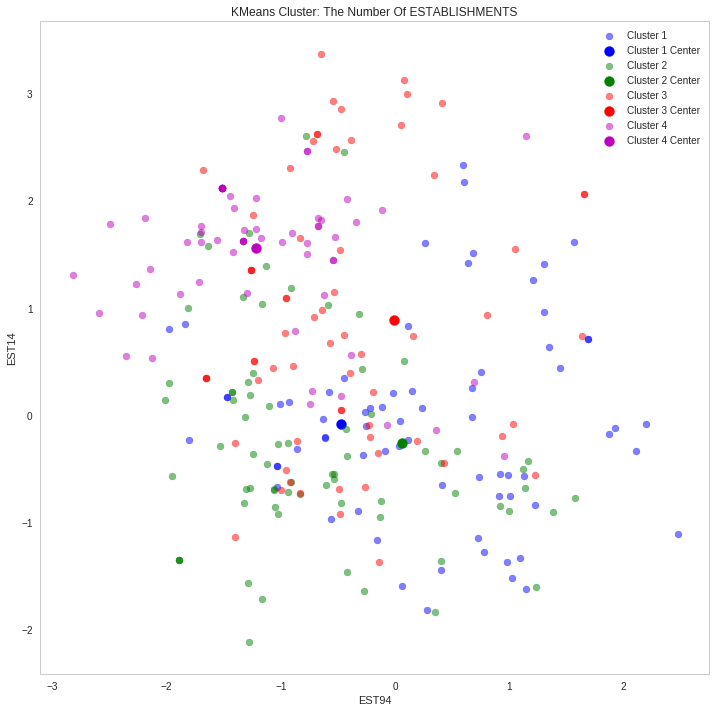

In [79]:
pl.figure(figsize=(12,12))
pl.scatter(df3[rr.labels_ == 0].iloc[:,0], df3[rr.labels_ == 0].iloc[:,20], \
           c='b', alpha=0.5, label="Cluster 1")
pl.scatter(centers[0][0], centers[0][-1], marker='o', s=100, c='b', label="Cluster 1 Center")

pl.scatter(df3[rr.labels_ == 1].iloc[:,0], df3[rr.labels_ == 1].iloc[:,20], \
           c='g', alpha=0.5, label="Cluster 2")
pl.scatter(centers[1][0], centers[1][-1], marker='o', s=100, c='g', label="Cluster 2 Center")

pl.scatter(df3[rr.labels_ == 2].iloc[:,0], df3[rr.labels_ == 2].iloc[:,20], \
           c='r', alpha=0.5, label="Cluster 3")
pl.scatter(centers[2][0], centers[2][-1], marker='o', s=100, c='r', label="Cluster 3 Center")

pl.scatter(df3[rr.labels_ == 3].iloc[:,0], df3[rr.labels_ == 3].iloc[:,20], \
           c='m', alpha=0.5, label="Cluster 4")
pl.scatter(centers[3][0], centers[3][-1], marker='o', s=100, c='m', label="Cluster 4 Center")

pl.xlabel("EST94")
pl.ylabel("EST14")
pl.title("KMeans Cluster: The Number Of ESTABLISHMENTS")
pl.legend(fontsize=10, loc='best')

### Perform the Hierarchical Clustering
As the scipy linkage docs tell us, 'ward' is one of the methods that can be used to calculate the distance between newly formed clusters. 'ward' causes linkage() to use the Ward variance minimization algorithm.

* other common linkage methods like 'single', 'complete', 'average', ... and the different distance metrics like 'euclidean' (default), 'cityblock' aka Manhattan, 'hamming', 'cosine'...

code from: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [23]:
# generate the linkage matrix
X= df3.iloc[:,range(0,20)]
Z = linkage(X, 'ward')

In [24]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
c

0.54854063962682709

Another thing you can and should definitely do is check the Cophenetic Correlation Coefficient of your clustering with help of the cophenet() function. This (very very briefly) compares (correlates) the actual pairwise distances of all your samples to those implied by the hierarchical clustering. The closer the value is to 1, the better the clustering preserves the original distances, which in this case is not very close

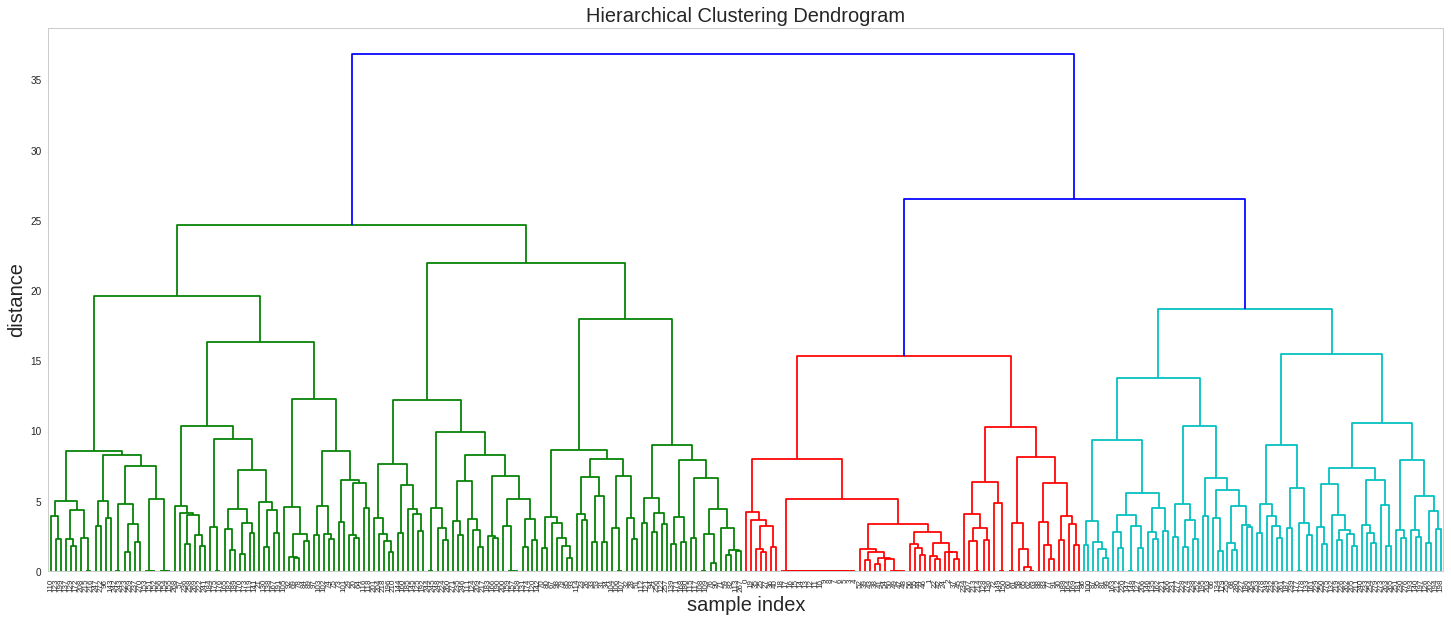

In [80]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
plt.xlabel('sample index', fontsize=20)
plt.ylabel('distance', fontsize=20)
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [26]:
k=4
den_label = fcluster(Z, k, criterion='maxclust')

overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters

In [27]:
df3['kmeans'] = rr.labels_
df3['Dendrogram'] = den_label

In [33]:
crs = {'init': 'epsg:4326'}
gdf = GeoDataFrame(df3, crs=crs, geometry='geometry')

In [35]:
gdf.head()

,94,95,96,97,98,99,00,01,02,03,...,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,kmeans,Dendrogram
0,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981958.6472873986 213464.4530421346,...",0,3
1,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((991339.8703228086 207576.7837151289,...",3,3
2,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989830.469142139 207048.1263078749, ...",3,3
3,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981197.408652395 196571.0816452205, ...",3,3
4,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((972696.8446168154 193014.5477478057,...",3,3


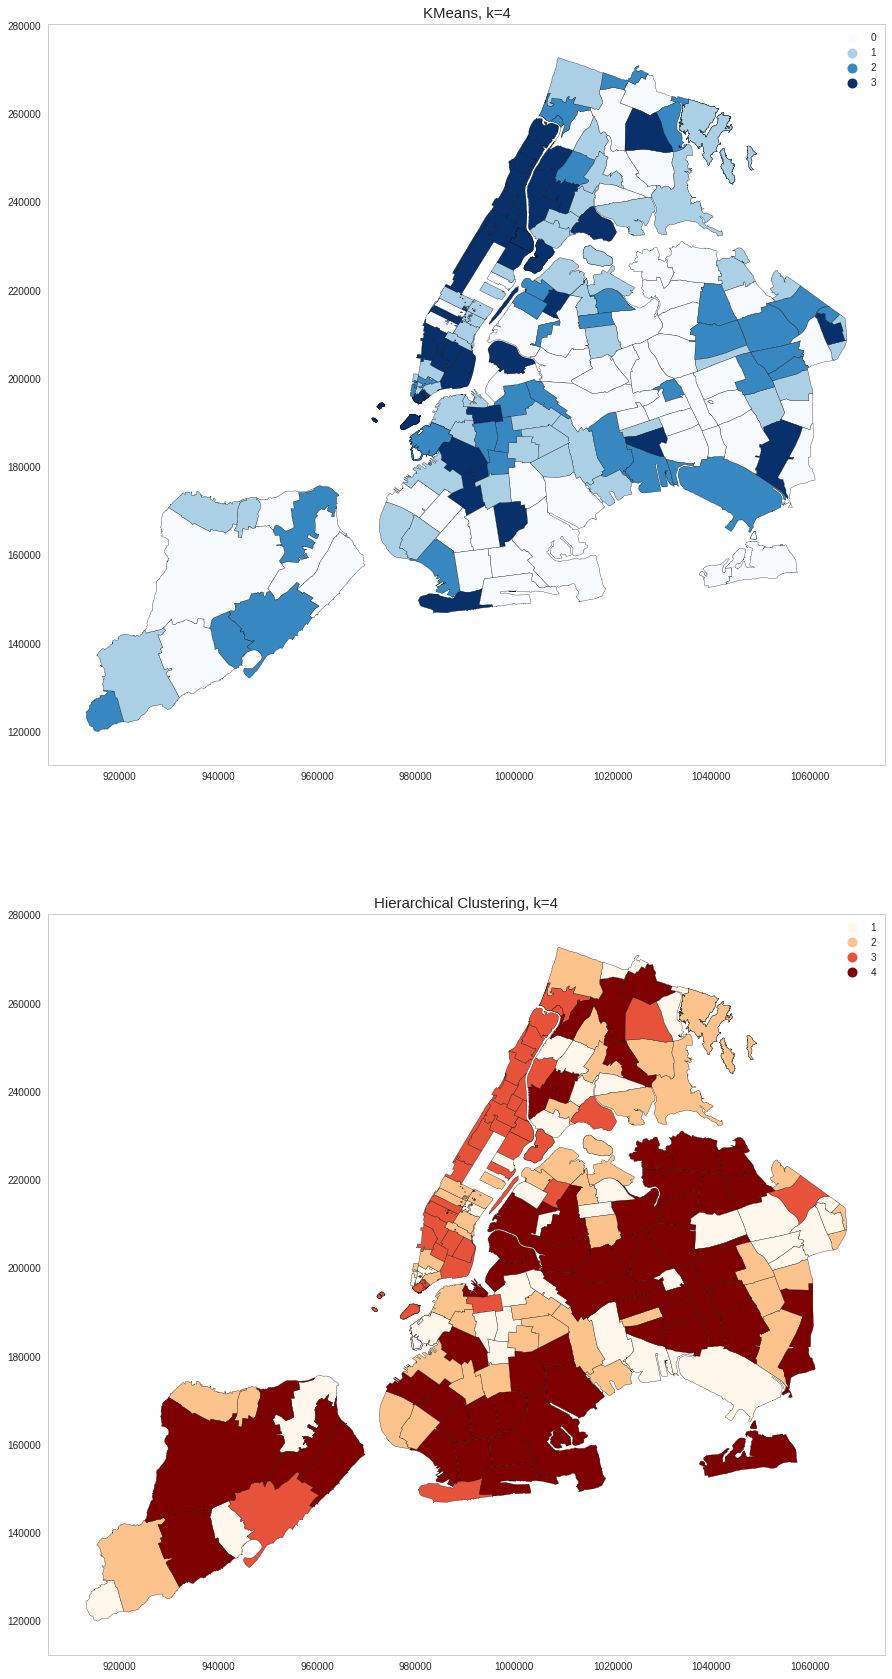

In [84]:
# plot the choropleth of the percentage of households with broadband access
fig = plt.figure(figsize = (15,30))
ax = fig.add_subplot(211)
ax1 = fig.add_subplot(212)
gdf.plot(ax=ax, colormap='Blues', column='kmeans', categorical=True, edgecolor='k', k=4, legend=True)
ax.set_title("KMeans, k=4", fontsize=15)
gdf.plot(ax=ax1, colormap='OrRd', column='Dendrogram', categorical=True, edgecolor='k', k=4, legend=True)
ax1.set_title("Hierarchical Clustering, k=4", fontsize=15)
